In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import compute_pw_dist_sqr
import torch
from diffusion import DDPMDynamic

In [2]:
ode_samples = np.load("results/ode_samples_true.npz")
x, states, ll = ode_samples.values()

In [3]:
train_data = np.load("results/train_data.npy")

In [4]:
alpha_bar = DDPMDynamic().alpha_bar
temp = (1 - alpha_bar) / alpha_bar


def compute_ll_given_data(data, states):
    bs, ts, *_ = states.shape

    dist_sqr = compute_pw_dist_sqr(
        torch.tensor(data.reshape(len(data), -1)),
        (states / alpha_bar.sqrt()[:, None, None, None]).reshape(bs * ts, -1)
    ).reshape(-1, bs, ts)


    pows = -dist_sqr / (2 * temp)
    max_pows = pows.max(0).values
    ll = (pows - max_pows).exp().mean(0).log() + max_pows

    d = np.prod(data.shape[1:])
    ll -= 0.5 * d  * np.log(2 * np.pi)
    ll -= 0.5 * d * (1 - alpha_bar).log()

    return ll

In [5]:
true_ll = compute_ll_given_data(train_data, states)
ll_with_generated_samples = compute_ll_given_data(x, states)

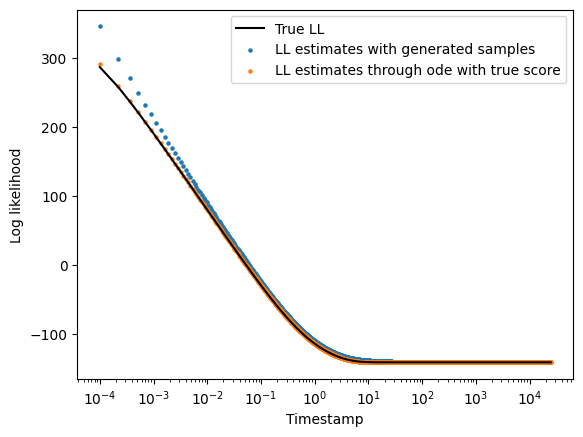

In [6]:
plt.plot(temp, true_ll.mean(0), label="True LL", c="black")
plt.scatter(temp, ll_with_generated_samples.mean(0), label="LL estimates with generated samples", s=5)
plt.scatter(temp, ll.mean(0)[1:], label="LL estimates through ode with true score", s=5)
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Log likelihood")
plt.xscale("log")
plt.show()